In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import os
from os import listdir as ls

In [2]:
import numpy as np
import matplotlib
import pickleshare
import sklearn
import skimage
from skimage.draw import line
from skimage.morphology import thin

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import argparse
import cv2
import one_hot
import pickle

In [4]:
print(skimage.__version__)

0.19.3


In [5]:
cv2.__version__

'4.6.0'

# Phase I: Pre-process Data

The original data is in inkml files, we first perform the following steps in terminal
* Extracts trace groups from inkml files.
* Converts extracted trace groups into images. Images are square shaped bitmaps with only black (value 0) and white (value 1) pixels. Black color denotes patterns (ROI).
* Labels those images according to inkml files.
* Flattens images to one-dimensional vectors.
* Converts labels to one-hot format.
* Dumps training and testing sets separately into outputs folder.

In [6]:
path = '/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/'
data_dir = os.path.join(path, 'CROHME_full_v2/')
ls(data_dir)

['CROHME2013_data',
 'index.html',
 'CROHME_papers',
 'CROHME2012_data',
 'evaluationTools',
 'ParticipantsResults2012',
 'readme.txt',
 'CROHME2011_data',
 '.ipynb_checkpoints']

In [7]:
test_path = path+'outputs/test/'
train_path = path+'outputs/train/'

In [8]:
train_data = pd.read_pickle(train_path+'train.pickle', compression='infer')
len(train_data)

310904

In [9]:
test_data = pd.read_pickle(test_path+'test.pickle', compression='infer')
len(test_data)

5499

In [10]:
num_classes = test_data[0]['label'].size
num_classes

101

In [11]:
test_data[5]['features'].size

784

In [12]:
train_ds = pd.DataFrame(train_data)
train_ds

,features,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...
310899,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310900,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310901,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
310902,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
test_ds = pd.DataFrame(test_data)
test_ds

,features,label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
5494,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5495,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5496,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5497,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Step 2: Balance the data set using terminal 

command line argument: python balance.py -b 28 -ub 5000

Build ResNet Model

In [14]:
train_feature_values = train_ds['features'].values

In [15]:
train_label_values = train_ds['label'].values

In [16]:
test_feature_values = test_ds['features'].values
test_label_values = test_ds['label'].values

In [17]:
train_feature_tensor = tf.convert_to_tensor(train_feature_values.tolist())

In [18]:
train_feature_tensor

<tf.Tensor: shape=(310904, 784), dtype=float32, numpy=
array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.28088683,
        1.        ]], dtype=float32)>

In [19]:
train_label_tensor = tf.convert_to_tensor(train_label_values.tolist())

In [20]:
train_label_tensor

<tf.Tensor: shape=(310904, 101), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [21]:
test_feature_tensor = tf.convert_to_tensor(test_feature_values.tolist())

In [22]:
test_feature_tensor

<tf.Tensor: shape=(5499, 784), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>

In [23]:
test_label_tensor = tf.convert_to_tensor(test_label_values.tolist())

In [24]:
test_label_tensor

<tf.Tensor: shape=(5499, 101), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [39]:
model_dense = tf.keras.Sequential([
    tf.keras.layers.InputLayer((784)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # The output layer has 101 nodes since we have 101 classes for this balanced data
    # with 10 digits and 37 letters
    tf.keras.layers.Dense(101, activation = 'softmax')
])

In [40]:
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 101)               13029     
Total params: 246,885
Trainable params: 246,885
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_dense.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [42]:
history_dense = model_dense.fit(train_feature_tensor, train_label_tensor, epochs=5)

Epoch 1/5
9716/9716 [==============================] - 17s 2ms/step - loss: 1.0504 - acc: 0.7047
Epoch 2/5
9716/9716 [==============================] - 17s 2ms/step - loss: 0.5495 - acc: 0.8261
Epoch 3/5
9716/9716 [==============================] - 17s 2ms/step - loss: 0.4538 - acc: 0.8524
Epoch 4/5
9716/9716 [==============================] - 17s 2ms/step - loss: 0.4043 - acc: 0.8668
Epoch 5/5
9716/9716 [==============================] - 17s 2ms/step - loss: 0.3734 - acc: 0.8772


In [45]:
model_dense.evaluate(test_feature_tensor, test_label_tensor, batch_size = 1)

5499/5499 [==============================] - 6s 1ms/step - loss: 1.2300 - acc: 0.7423


[1.2299532890319824, 0.7423167824745178]

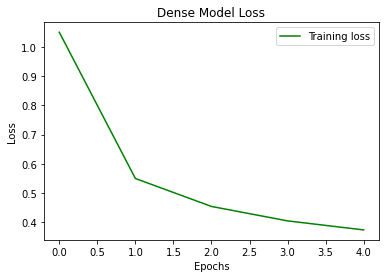

In [44]:
loss_train = history_dense.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.title('Dense Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_loss.png")
plt.show()

After 5 epochs, the pure dense model has test accuracy higher than 74% percent. 
Although the model still has over-fitting problem, the accuracy is higher than we expected. 
We think using a dense network trained on flattened image is a good option for the math symbol dataset.

# Use ResNet

In [25]:
train_image_ds = train_ds

In [26]:
for i in range(len(train_image_ds)):
    arr = train_image_ds['features'][i]
    train_image_ds['features'][i] = arr.reshape((28,28,1))

In [27]:
test_image_ds = test_ds

In [28]:
for i in range(len(test_image_ds)):
    arr = test_image_ds['features'][i]
    test_image_ds['features'][i] = arr.reshape((28,28,1))

In [29]:
train_image_values = train_image_ds['features'].values
test_image_values = test_image_ds['features'].values

In [30]:
train_image_tensor = tf.convert_to_tensor(train_image_values.tolist())

In [31]:
test_image_tensor = tf.convert_to_tensor(test_image_values.tolist())

In [32]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

In [33]:
model = ResNet50()

In [34]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [35]:
model_config = model.get_config()

/opt/pub/eb/apps/cascadelake/TensorFlow/2.5.0-fosscuda-2020b/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [56]:
input_layer_name = model_config['layers'][0]['name']
input_layer_name

'our_input'

In [91]:
model_config['layers'][1]

{'class_name': 'ZeroPadding2D',
 'config': {'name': 'conv1_pad',
  'trainable': True,
  'dtype': 'float32',
  'padding': ((3, 3), (3, 3)),
  'data_format': 'channels_last'},
 'name': 'conv1_pad',
 'inbound_nodes': [[['our_input', 0, 0, {}]]]}

In [58]:
model_config['layers'][0]

{'name': 'our_input',
 'class_name': 'InputLayer',
 'config': {'batch_input_shape': (None, 28, 28, 1),
  'dtype': 'float32',
  'sparse': False,
  'ragged': False,
  'name': 'our_input'},
 'inbound_nodes': []}

In [39]:
model_config['layers'][0] = {
                      'name': 'our_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None, 28, 28, 1),
                          'dtype': 'float32',
                          'sparse': False,
                          'ragged': False,
                          'name': 'our_input'
                      },
                      'name': 'our_input',
                      'inbound_nodes': []
                  }
model_config['layers'][1]['inbound_nodes'] = [[['our_input', 0, 0, {}]]]
model_config['input_layers'] = [['our_input', 0, 0]]

In [92]:
new_model = model.__class__.from_config(model_config, custom_objects={})

In [93]:
new_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
our_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 1)    0           our_input[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 14, 14, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 14, 14, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [94]:
new_model.layers[167].trainable

True

In [90]:
len(new_model.layers)

177

In [95]:
# Set the last 9 layers to be trainable gives us the highest accuracy after around 20 trials using 1, 3, 6, 9, 12, and 16.
for i in range(1,len(new_model.layers)-9):
    new_model.layers[i].trainable = False

In [96]:
new_model.layers[167].trainable

False

In [97]:
new_model.layers[168].trainable

True

In [98]:
new_model.layers[168]

In [99]:
output_layer = tf.keras.layers.Dense(101, activation = 'softmax')

In [100]:
model_res = tf.keras.Sequential([new_model, output_layer])

In [101]:
model_res.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25630440  
_________________________________________________________________
dense_3 (Dense)              (None, 101)               101101    
Total params: 25,731,541
Trainable params: 5,565,653
Non-trainable params: 20,165,888
_________________________________________________________________


In [102]:
model_res.compile(optimizer = tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [103]:
history_resnet = model_res.fit(train_image_tensor, train_label_tensor, batch_size=32, epochs=15)

Epoch 1/7
9716/9716 [==============================] - 187s 19ms/step - loss: 3.7193 - acc: 0.0725
Epoch 2/7
9716/9716 [==============================] - 185s 19ms/step - loss: 3.0552 - acc: 0.1988
Epoch 3/7
9716/9716 [==============================] - 181s 19ms/step - loss: 2.5198 - acc: 0.3581
Epoch 4/7
9716/9716 [==============================] - 182s 19ms/step - loss: 2.0344 - acc: 0.4995
Epoch 5/7
9716/9716 [==============================] - 125s 13ms/step - loss: 1.6702 - acc: 0.6068
Epoch 6/7
9716/9716 [==============================] - 123s 13ms/step - loss: 1.4184 - acc: 0.6672
Epoch 7/7
9716/9716 [==============================] - 123s 13ms/step - loss: 1.2366 - acc: 0.7077


In [104]:
model_res.evaluate(test_image_tensor, test_label_tensor, batch_size=1)

5499/5499 [==============================] - 56s 10ms/step - loss: 2.3750 - acc: 0.4388


[2.375030994415283, 0.43880707025527954]

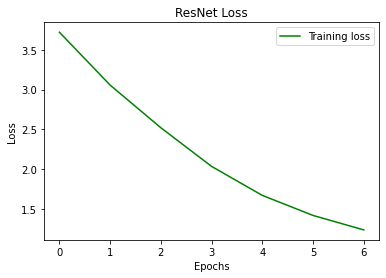

In [105]:
loss_train = history_resnet.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.title('ResNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_loss.png")
plt.show()

In [54]:
# del new_model
# del model_res

# Conclusion: 

# Installation Code saved in this section: 

* ls("/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/")
* path_zip = '/home/DAVIDSON/mawang1/Workspace/CSC381/implementation-project-dl-f22-hueynataliemaureenilina/'
* import zipfile
with zipfile.ZipFile('CROHME_full_v2.zip', 'r') as zip_ref:
    zip_ref.extractall(path_zip)
* !pip install scikit-image
* !pip install opencv-python
* Command Line Argument: -b [BOX_SIZE] -d [DATASET_VERSION] -c [CATEGORY] -t [THICKNESS]
* image1 = tf.keras.preprocessing.image.load_img('out.png')

# Citation: 
* Dataset Explanation: https://www.cs.rit.edu/~dprl/old/CROHMELib_LgEval_Doc.html
* Python Program for Extracting Data: https://github.com/ThomasLech/CROHME_extractor
* Dataset Official Web Page: http://www.iapr-tc11.org/mediawiki/index.php?title=CROHME:_Competition_on_Recognition_of_Online_Handwritten_Mathematical_Expressions
* ResNet Academic Paper: https://arxiv.org/abs/1512.03385
* ResNet50 Tensorflow: https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691
* OCR using Tensorflow: https://medium.com/analytics-vidhya/optical-character-recognition-using-tensorflow-533061285dd3